[Paper url](https://espace.curtin.edu.au/bitstream/handle/20.500.11937/18325/226558_153096_final_version_7.pdf?sequence=2)

In [5]:
using DifferentialEquations
using Plots

# MODELLING AND OPTIMAL CONTROL OF BLOOD GLUCOSE LEVELS IN THE HUMAN BODY


Note: 
- The paper expands on the model developed by Liu and Tang in [Modeling a simplified regulatory system of blood glucose at molecular levels - Liu and Tang (2008)](https://www.sciencedirect.com/science/article/abs/pii/S0022519308000829?via%3Dihub)
- The model is optimized to match the experimental data collected by Korach-André et al in [Glucose appearance in the peripheral circulation and liver glucose output in men after a large 13C starch meal (2004)](https://academic.oup.com/ajcn/article/80/4/881/4690391) as closely as possible

## 2. Mathematical model

The dynamic model of Liu and Tang is made up of eight state variables

```
x1 = concentration of plasma glucagon (in moles per liter);
x2 = concentration of plasma insulin (in moles per liter);
x3 = intracellular concentration of glucagon (in moles per liter);
x4 = intracellular concentration of insulin (in moles per liter);
x5 = concentration of glucagon receptor (in moles per liter);
x6 = concentration of insulin-bound receptor (in moles per liter);
x7 = blood concentration of glycogen (in milligrams per liter);
x8 = blood concentration of glucose (in milligrams per liter).
```

### 2.1 Insulin and glucagon transition subsystem

The model assumes that plasma insulin does not act directly on the glucose
metabolism, but instead through remote cellular insulin. The model also assumes
that intracellular insulin does not move back to plasma. 

In [2]:
w1(Gm, b1, a1, x8, C5) = Gm/(1+b1*exp(a1(x8-C5)))
w2(Rm, b2, a2, x8, C1) = Rm/(1+b2*exp(a2(C1-x8)))

dx1_dt(kp_11, kp_12, x1) = -(kp_11 + kp_12)*x1 + w1
dx2_dt(kp_21, kp_22, x1) = -(kp_21 + kp_22)*x2 + w2

# Where
#  Gm = maximum glucagon infusion rate
#  a1, a2, b1, b2, and C5 are positive constants
#  kp_i1 is a transition rate, and kp_i2 is a degragation rate

# Note: 
# - w1 & w2, model natural feedback control mechanisms
# - The differential equations do actually describe the actual state changes of glucagon  or insulin, 
#   either the current amount moves transitions into another form (or degrades), or more is created as described by w
#    - w1 & w2 do represent an added amount since equation 1/(1 + e^x) assyptotes around 1 & 0, 
#      so the additional constants modify the shape of this original equation as needed       

dx2_dt (generic function with 1 method)

### 2.2 Insulin and glucagon receptor binding subsystem

The model assumes that receptor recycling is a closed subsystem; the synthesis rate of receptors is equal to their degradation rate

In [4]:
dx3_dt(ks_11, ks_12, x1, x3, R0_1, V, Vp) = -ks_11*x3*(R0_1 - x5) - ks_12x3 + (kp_11*Vp*x1)/V
dx4_dt(ks_21, ks_22, x2, x4, R0_2, V, Vp) = -ks_21*x4*(R0_2 - x6) - ks_22x4 + (kp_21*Vp*x2)/V
dx5_dt(ks_11, kr_1, x_3, x_5, R0_1) = -ks_11*x3*(R0_1 - x5) - kr_1*x5
dx6_dt(ks_21, kr_2, x_4, x_6, R0_2) = -ks_21*x4*(R0_2 - x6) - kr_2*x6

# Where
#  - ks_i1 are the hormone-receptor association rates
#  - ks_i2 are the degragation rates
#  - R0_i are the total concentration of receptors
#  - kr_i are inactivation rates
#  - Vp is the plasma insulin volume
#  - V is the cellular insulin volume

dx6_dt (generic function with 1 method)

### 2.3. Glucose production and utilization subsystem

Plasma glucose has two sources: hepatic glucose produced by converting glycogen into glucose in the liver and exogenous glucose taken from food. Glucose utilization can be classified into two classes: insulin-independent (by brain and nerve cells) and insulin-dependent (by the muscle and fat cells)

In [11]:
f1(Ub, C2, x8) = Ub*(1 - exp(-(x8/C2)))
f2(C3, x8) = x8/C3
f3(U0, Um, C4, beta, x4) = U0 + (((Um-U0)*x4^beta)/(C4^beta + X4^beta))
f4(k1, k2, kgs_m, x5, x6, x8, Vgs_max) = ((k1*x6)/(1 + k2*x5))*((Vgs_max*x8)/(kgs_m + x8))
f5(k3, kgp_m, x5, x7, Vgp_max) = (k3*x5)*((Vgp_max*x7)/(kgp_m+x7))

dx7_dt(k1, k2, k3, kgs_m, kgp_m, x5, x6, x7, x8, Vgs_max, Vgp_max) = 
    (
        f4(k1, k2, kgs_m, x5, x6, x8, Vgs_max) 
        - f5(k3, kgp_m, x5, x7, Vgp_max)
    )
dx8_dt(k1, k2, k3, kgs_m, kgp_m, x5, x6, x7, x8, Vgs_max, Vgp_max, Ub, C2, C3, G) = 
    (
        -f4(k1, k2, kgs_m, x5, x6, x8, Vgs_max) 
        + f5(k3, kgp_m, x5, x7, Vgp_max) 
        - f1(Ub, C2, x8) 
        - f2(C3, X8)*f3(U0, Um, C4, beta, x4) 
        + G
    )

# Where
#  - k1, k2 and k3 are the feedback control gains
#  - Vgp_max is the maximum velocity of glycogen phosphorylase
#  - Vgs_max is the maximum velocity of glycogen synthase
#  - kgs_m and kgp_m are the Michaelis-Menton constants
#  - U0, Ub, Um, C2, C3, C4 and β are positive constants
#  - G is the exogenous glucose intake derived from digesting food

dx8_dt (generic function with 1 method)

### 2.4. Initial conditions and model constants

In [12]:
9*60

540

Assume system is modeled over 9 hour period so `t \in [0, 540]` for t in minutes.

Initial values of the variables for Liu and Tang are:

```
x1(0) = 1.4 × 10−11, (16)
x2(0) = 1.389 × 10−11, (17)
x3(0) = 0, (18)
x4(0) = 6.945 × 10−14, (19)
x5(0) = 0, (20)
x6(0) = 0, (21)
x7(0) = 200, (22)
x8(0) = 918. (23)
```

In [14]:
# Constants as described by & updated in consultation with Liu and Tang (details in paper)

kp_11 = 0.14 # min−1 uncertain
kp_21 = 0.14 # min−1 uncertain
kp_12 = 0.3 # min−1 well-defined
kp_22 = 1/6 # min−1 uncertain
ks_11 = 6*10^7 # M−1 min−1 well-defined
ks_21 = 6*10^7 # M−1 min−1 well-defined
ks_12 = 0.01 # min−1 uncertain
ks_22 = 0.01 # min−1 uncertain
kr1 = 0.2 # min−1 uncertain
kr2 = 0.2 # min−1 uncertain
R01 = 9*10^-13 # M well-defined
R02 = 3.6114 * 10^(−12) # M well-defined
Vgp_max = 80 # mg/l/min uncertain
kgp_m = 600 # mg/l well-defined
Vgs_max = 3.87 * 10^(−4) # mg/l/min uncertain
kgs_m = 67 # mg/l well-defined
k1 = 2.76900924 * 10^11 # M−1 well-defined
k2 = 1.1111111 * 10^14 # M−1 well-defined
k3 = 1.1111111 * 10^12 # M−1 well-defined
V = 11 # l uncertain
Vp = 3 # l uncertain
Ub = 7.2 # mg/l/min uncertain
U0 = 4 # mg/l/min uncertain
Um = 94 # mg/l/min uncertain
Gm = 2.23 * 10^(−10) # M/min uncertain
Rm = 4.8615 * 10^(−10) # M/min uncertain
C1 = 2000 # mg/l uncertain
C2 = 144 # mg/l uncertain
C3 = 1000 # mg/l uncertain
C4 = 5.556 * 10^(−10) # mg/l uncertain
C5 = 1000 # mg/l uncertain
beta = 1.77 # - uncertain
a1 = 0.005 # (mg/l)−1 uncertain
a2 = 1/300 # (mg/l)−1 uncertain
b1 = 10 # - uncertain
b2 = 1 # - uncertain

1

## 3. Parameter estimation

In [52]:
healthy_individual_glucose_measurements = [
    [0, 60, 120, 150, 180, 240, 380, 420, 540] [900, 1785.29, 1530.27, 1330.88, 1300.55, 1244.95, 1113.53, 1078.2, 900.72]
]

9×2 Matrix{Float64}:
   0.0   900.0
  60.0  1785.29
 120.0  1530.27
 150.0  1330.88
 180.0  1300.55
 240.0  1244.95
 380.0  1113.53
 420.0  1078.2
 540.0   900.72

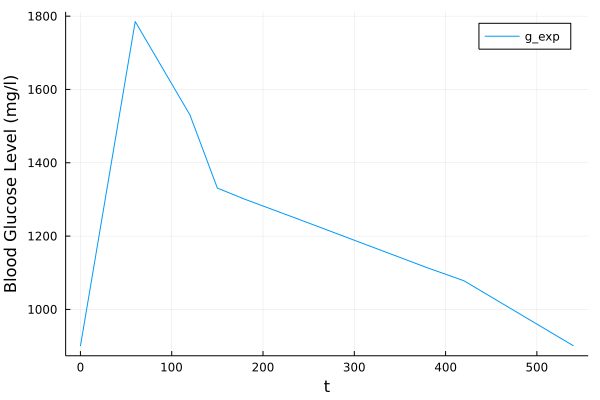

In [60]:
plot(
    healthy_individual_glucose_measurements[:, 1], 
    healthy_individual_glucose_measurements[:, 2],
    label = "g_exp",
    xlabel = "t",
    ylabel = "Blood Glucose Level (mg/l)",
)